In [1]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2


# import standard libs
from IPython.display import display
from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import json
import datetime
import pickle


# import python scientific stack
import pandas as pd
import pandas_datareader.data as web
pd.set_option('display.max_rows', 10)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
from multiprocessing import cpu_count
pbar = ProgressBar()
pbar.register()
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math
# import ffn


# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')
#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

RANDOM_STATE = 777

print()

Last updated: 2024-09-02T11:26:54.459038-04:00

Python implementation: CPython
Python version       : 3.8.19
IPython version      : 8.12.2

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit




/var/folders/j0/8v9qcjfx15g5ftmsy5n0qrq80000gn/T/ipykernel_43381/2173331131.py:46: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-talk')


In [2]:
import os

# Run the setup script
%run ../../config/setup_project.py

# Call the function to set up the project path
setup_project_path()

# Now you can import your modules
from utils import helper as h_
import ch_02.code_ch_02 as f_ch2
import ch_03.code_ch_03 as f_ch3
import ch_05.code_ch_05 as f_ch5

Project root added to sys.path: /Users/paulkelendji/Desktop/GitHub_paul/ML-Asset_Management/src
Current sys.path: ['/Users/paulkelendji/miniconda3/envs/financial_math/lib/python38.zip', '/Users/paulkelendji/miniconda3/envs/financial_math/lib/python3.8', '/Users/paulkelendji/miniconda3/envs/financial_math/lib/python3.8/lib-dynload', '', '/Users/paulkelendji/miniconda3/envs/financial_math/lib/python3.8/site-packages', '/Users/paulkelendji/miniconda3/envs/financial_math/lib/python3.8/site-packages/setuptools/_vendor', '/Users/paulkelendji/Desktop/GitHub_paul/ML-Asset_Management/src']


# 8.3.1 Mean Decrese Impurity

**Mean Decrease Impurity (MDI)** is a method used in tree-based models, like Random Forests, to determine the importance of different features in making predictions. It’s a measure of how much each feature contributes to reducing uncertainty or “impurity” in the model’s decision-making process. 

### Understanding Impurity
In decision trees, **impurity** refers to the measure of disorder or uncertainty in a dataset at a given node. Common impurity measures include:

1. **Gini Impurity**: Used in classification tasks, it quantifies the likelihood of misclassifying a randomly chosen element from the dataset. A node is pure (Gini = 0) if all its samples belong to the same class.
  
2. **Entropy**: Also used in classification tasks, it measures the unpredictability or randomness of the data at a node. A pure node has an entropy of 0, meaning it contains only one class.

3. **Variance Reduction**: In regression trees, impurity is often measured by the reduction in variance when the data is split. The goal is to minimize the variance within each group created by the split.

### How MDI Works
- **Splitting the Data**: At each node in a decision tree, the algorithm chooses a feature and a threshold that best splits the data to reduce impurity. For instance, in a classification tree, it might split based on a feature value that best separates different classes.

- **Calculating the Decrease in Impurity**: Once a split is made, the reduction in impurity is calculated. This reduction is attributed to the feature used for the split. The larger the reduction, the more important the feature is considered to be.

- **Averaging Over Trees**: In Random Forests, which consist of many decision trees, this process is repeated for each tree. The importance of a feature is then averaged over all trees in the forest, giving a measure of its overall importance.

### Importance in Feature Selection
MDI helps identify which features are most influential in the model's predictions. However, it is sensitive to substitution effects, meaning that correlated features can "share" importance, reducing the apparent importance of each individual feature.

### Substitution Effects
Substitution effects in MDI occur when the importance of a feature is diluted because it shares similar information with other features. For instance, if two features are highly correlated, the model might use one or the other interchangeably, leading to a lower importance score for each.

To mitigate substitution effects, Principal Component Analysis (PCA) can be applied to create orthogonal (uncorrelated) features before applying MDI, ensuring that the importance scores reflect the unique contribution of each feature.

### Summary
MDI is a widely used, fast method for determining feature importance in tree-based models by analyzing how much each feature reduces impurity in the model’s decision-making process. It's useful for understanding which features are most critical to the model but needs to be used with care when features are correlated.

In [3]:
### SNIPPET 8.2 MDI FEATURE IMPORTANCE

def featImpMDI(fit, featNames):
    # feat importance based on IS mean impurity reduction
    df0 = {i: tree.feature_importances_ for i, tree in enumerate(fit.estimators_)}
    df0 = pd.DataFrame.from_dict(df0, orient='index')
    df0.columns = featNames
    df0 = df0.replace(0, np.nan)  # because max_features=1

    imp = pd.concat({'mean': df0.mean(), 'std': df0.std() * df0.shape[0] ** -.5}, axis=1)
    imp /= imp['mean'].sum()
    return imp


In the context of the Mean Decrease Accuracy (MDA) algorithm, sample weights play a crucial role in adjusting the importance of individual observations during both model training and evaluation. Here’s a breakdown of how they are used:

### Role of Sample Weights in MDA

1. **Model Training**:
   - **Weighted Learning**: When fitting the classifier (`clf.fit`), sample weights (`sample_weight=w0.values`) are passed to the model. These weights adjust the influence of each training sample on the model's learning process. For example, if certain samples are more important or represent more frequent occurrences in real-world data, they can be assigned higher weights, making the model pay more attention to them during training. This ensures that the model is trained in a way that reflects the weighted distribution of the data.

2. **Performance Scoring**:
   - **Weighted Scoring**: After the model is trained, its performance is evaluated on the out-of-sample (OOS) test data. Sample weights (`sample_weight=w1.values`) are also used during this evaluation phase. In this context, they adjust the calculation of performance metrics like accuracy or negative log-loss. For instance, a sample with a higher weight will contribute more to the overall performance score than a sample with a lower weight. This allows the evaluation to reflect the importance of different samples according to their assigned weights.

3. **Permutation Step**:
   - **Consistency with Original Scoring**: During the permutation step (where individual features are shuffled to assess their importance), the performance of the model is again evaluated using weighted scoring. This ensures that the impact of each feature on the model's performance is measured consistently with how the model was trained and initially evaluated.

### Why Use Sample Weights?

- **Handling Class Imbalance**: If the dataset is imbalanced (i.e., one class is more frequent than others), sample weights help the model to avoid bias towards the majority class. By assigning higher weights to the minority class samples, the model is encouraged to learn from them more effectively.
  
- **Reflecting Data Importance**: In some cases, certain samples may be more critical than others (e.g., due to their relevance in a business context). Sample weights allow you to reflect this importance in both training and evaluation phases.

- **Correcting for Over/Under-sampling**: If the dataset has been over-sampled or under-sampled to address imbalance issues, sample weights can be used to correct the impact of these adjustments.

In summary, sample weights in the MDA algorithm ensure that both the model's learning process and the evaluation of feature importance are conducted in a way that respects the relative importance of each sample, leading to more reliable and context-aware insights from the model.

---

The situation described in the quote occurs due to the way Mean Decrease Accuracy (MDA) handles correlated features during the feature importance evaluation process.

### Why MDA Might Make Correlated Features Seem Irrelevant

1. **How MDA Works**: 
   - MDA measures the importance of a feature by evaluating the drop in model performance when that feature's values are randomly shuffled (permuted). If the model's performance drops significantly, it indicates that the feature was important.

2. **Substitution Effect**: 
   - When two features are highly correlated or nearly identical, they both provide similar information to the model. This redundancy means that if one of these features is permuted (shuffled), the other feature can still provide the same information to the model. As a result, the model's performance might not drop significantly when either feature is permuted, leading to the conclusion that neither feature is particularly important.

3. **Redundancy and Perceived Irrelevance**:
   - Since both correlated features substitute for each other, MDA can mistakenly view both as unimportant, even though they might be crucial for the model's performance when considered together. This happens because the permuting of one feature doesn’t significantly impact the model if the other correlated feature remains intact.

4. **Critical Features Appearing Irrelevant**:
   - The critical issue arises because MDA evaluates each feature independently without considering the joint contribution of correlated features. Thus, when features are highly correlated, the shuffling of one does not reveal its true importance, as the model compensates with the other correlated feature. This can lead to both features being incorrectly deemed unimportant, even if they are critical when considered together.

### Example Scenario

Imagine a dataset where two features, `Feature_A` and `Feature_B`, are almost identical (e.g., one is just a noisy version of the other). If `Feature_A` is shuffled, the model can still rely on `Feature_B`, so the performance doesn’t drop much. When `Feature_B` is shuffled, the model relies on `Feature_A`. Consequently, MDA might show that neither feature is important because the model's performance doesn't drop significantly in either case. However, if both were removed, the model’s performance would degrade, indicating that together, they were indeed important.

### Addressing This Issue

To address the issue of substitution effects in MDA:
- **PCA (Principal Component Analysis)**: This can be applied to transform correlated features into a set of uncorrelated components (principal components), on which MDA can then be applied.
- **Feature Grouping**: Grouping correlated features and treating them as a single entity during MDA might also help mitigate this issue.

This explanation highlights the key reasons why MDA might incorrectly downplay the importance of correlated features due to substitution effects.

---

In [4]:
### SNIPPET 8.3 MDA FEATURE IMPORTANCE

def featImpMDA(clf, X, y, cv, sample_weight, t1, pctEmbargo, scoring='neg_log_loss'):
    # feat importance based on OOS score reduction
    if scoring not in ['neg_log_loss', 'accuracy']:
        raise Exception('wrong scoring method.')
    
    from sklearn.metrics import log_loss, accuracy_score
    cvGen = PurgedKFold(n_splits=cv, t1=t1, pctEmbargo=pctEmbargo)  # purged cv
    scr0, scr1 = pd.Series(), pd.DataFrame(columns=X.columns)
    
    for i, (train, test) in enumerate(cvGen.split(X=X)):
        X0, y0, w0 = X.iloc[train, :], y.iloc[train], sample_weight.iloc[train]
        X1, y1, w1 = X.iloc[test, :], y.iloc[test], sample_weight.iloc[test]
        fit = clf.fit(X=X0, y=y0, sample_weight=w0.values)
        
        if scoring == 'neg_log_loss':
            prob = fit.predict_proba(X1)
            scr0.loc[i] = -log_loss(y1, prob, sample_weight=w1.values, labels=clf.classes_)
        else:
            pred = fit.predict(X1)
            scr0.loc[i] = accuracy_score(y1, pred, sample_weight=w1.values)
        
        for j in X.columns:
            X1_ = X1.copy(deep=True)
            np.random.shuffle(X1_[j].values)  # permutation of a single column
            
            if scoring == 'neg_log_loss':
                prob = fit.predict_proba(X1_)
                scr1.loc[i, j] = -log_loss(y1, prob, sample_weight=w1.values, labels=clf.classes_)
            else:
                pred = fit.predict(X1_)
                scr1.loc[i, j] = accuracy_score(y1, pred, sample_weight=w1.values)
    
    imp = (-scr1).add(scr0, axis=0)
    if scoring == 'neg_log_loss':
        imp = imp / -scr1
    else:
        imp = imp / (1. - scr1)
    
    imp = pd.concat({'mean': imp.mean(), 'std': imp.std() * imp.shape[0] ** -.5}, axis=1)
    return imp, scr0.mean()


In [19]:
# Install yfinance if you haven't already
# !pip install yfinance

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# Step 1: Fetch data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'TSLA', 'HSY', 'T', 'JNJ', 'PFE']
data = yf.download(tickers, start="2023-01-01", end="2023-12-31")['Adj Close']

# Step 2: Calculate daily returns
returns_data = data.pct_change().dropna()
returns_data


[*********************100%%**********************]  7 of 7 completed


Ticker,AAPL,HSY,JNJ,MSFT,PFE,T,TSLA
Date,,,,,,,
2023-01-04,0.010314,-0.016128,0.010887,-0.043743,-0.022044,0.021345,0.051249
2023-01-05,-0.010605,-0.000851,-0.007384,-0.029638,-0.009376,0.003657,-0.029039
2023-01-06,0.036794,0.011521,0.008110,0.011785,0.025372,0.016658,0.024651
2023-01-09,0.004089,-0.001152,-0.025908,0.009736,-0.049686,-0.011012,0.059349
2023-01-10,0.004456,-0.002707,-0.002392,0.007617,-0.015912,0.022584,-0.007681
...,...,...,...,...,...,...,...
2023-12-22,-0.005547,0.008398,0.004004,0.002784,0.003179,0.003638,-0.007701
2023-12-26,-0.002841,0.004821,0.004374,0.000214,0.000352,0.001208,0.016116
2023-12-27,0.000518,0.002835,0.001345,-0.001575,0.007040,0.000604,0.018822


Explained Variance Ratio by Principal Component:
[0.52825082 0.14192827 0.12391638 0.08462922 0.05613993 0.03575705
 0.02937834]

PCA Loadings:
           PC1       PC2       PC3       PC4       PC5       PC6       PC7
AAPL -0.197822  0.098809  0.378581  0.248852  0.066489 -0.751971  0.419489
MSFT -0.029384  0.167145  0.198818  0.125339  0.716193  0.471648  0.424943
TSLA -0.019633  0.233338  0.114452 -0.216905  0.563150 -0.311366 -0.686246
HSY  -0.196453  0.013563  0.775085  0.258198 -0.289965  0.321632 -0.325994
T    -0.050525  0.429547  0.250802 -0.801313 -0.210997  0.049859  0.246832
JNJ  -0.077339  0.841295 -0.291044  0.397173 -0.188189  0.061221 -0.068016
PFE  -0.955243 -0.124022 -0.235973 -0.093806  0.038656  0.073878 -0.026346


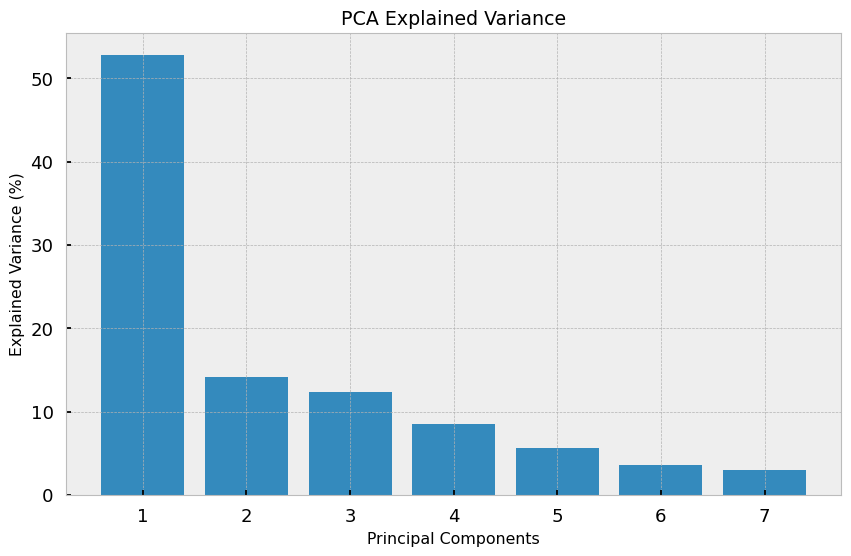

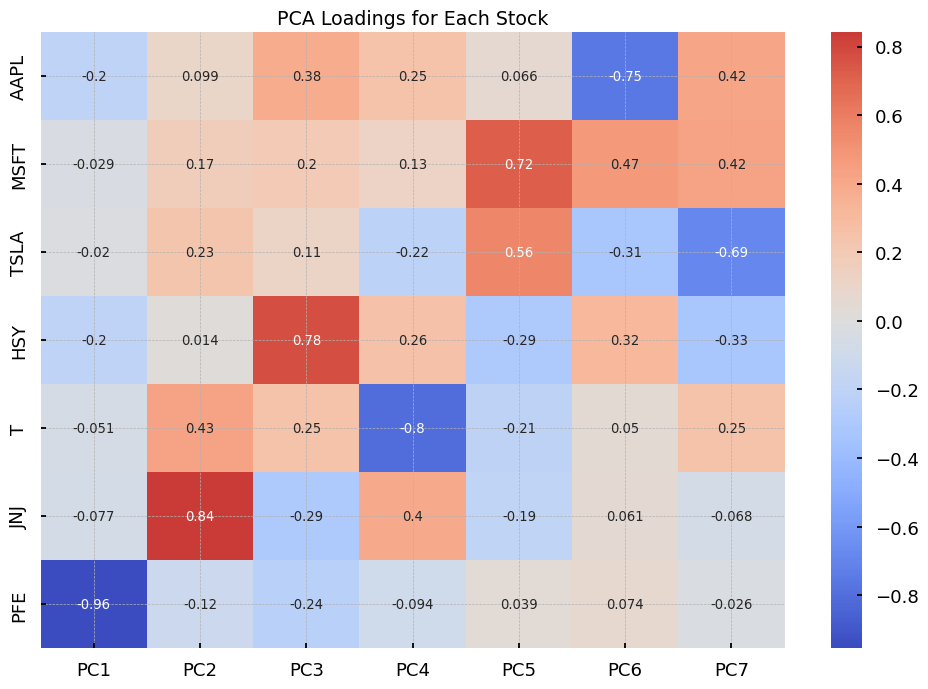


Stocks contributing most to each principal component:
PC1     PFE
PC2     JNJ
PC3     HSY
PC4       T
PC5    MSFT
PC6    AAPL
PC7    TSLA
dtype: object


In [20]:
# Step 3: Apply PCA
pca = PCA()
pca.fit(returns_data)

# Explained variance by each principal component
explained_variance = pca.explained_variance_ratio_

# Step 4: Analyze the PCA results
components = pca.components_

# Create a DataFrame to display the loadings (components)
pca_loadings = pd.DataFrame(components.T, index=tickers, columns=[f'PC{i+1}' for i in range(len(tickers))])

print("Explained Variance Ratio by Principal Component:")
print(explained_variance)

print("\nPCA Loadings:")
print(pca_loadings)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(tickers) + 1), explained_variance * 100)
plt.ylabel('Explained Variance (%)')
plt.xlabel('Principal Components')
plt.title('PCA Explained Variance')
plt.show()

# Visualizing PCA loadings
plt.figure(figsize=(12, 8))
sns.heatmap(pca_loadings, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Loadings for Each Stock')
plt.show()

# Determine which stock explains most of the portfolio's variance
max_variance_contributor = pca_loadings.abs().idxmax()
print("\nStocks contributing most to each principal component:")
print(max_variance_contributor)


In [21]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# Step 1: Fetch data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'TSLA', 'HSY', 'T', 'JNJ', 'PFE']
data = yf.download(tickers, start="2023-01-01", end="2023-12-31")['Adj Close']

# Step 2: Calculate daily returns
returns_data = data.pct_change().dropna()
returns_data


[*********************100%%**********************]  7 of 7 completed


Ticker,AAPL,HSY,JNJ,MSFT,PFE,T,TSLA
Date,,,,,,,
2023-01-04,0.010314,-0.016128,0.010887,-0.043743,-0.022044,0.021345,0.051249
2023-01-05,-0.010605,-0.000851,-0.007384,-0.029638,-0.009376,0.003657,-0.029039
2023-01-06,0.036794,0.011521,0.008110,0.011785,0.025372,0.016658,0.024651
2023-01-09,0.004089,-0.001152,-0.025908,0.009736,-0.049686,-0.011012,0.059349
2023-01-10,0.004456,-0.002707,-0.002392,0.007617,-0.015912,0.022584,-0.007681
...,...,...,...,...,...,...,...
2023-12-22,-0.005547,0.008398,0.004004,0.002784,0.003179,0.003638,-0.007701
2023-12-26,-0.002841,0.004821,0.004374,0.000214,0.000352,0.001208,0.016116
2023-12-27,0.000518,0.002835,0.001345,-0.001575,0.007040,0.000604,0.018822


In [22]:

# Step 3: Apply PCA
pca = PCA()
pca.fit(returns_data)

# Explained variance by each principal component
explained_variance = pca.explained_variance_ratio_
explained_variance


array([0.52825082, 0.14192827, 0.12391638, 0.08462922, 0.05613993,
       0.03575705, 0.02937834])

In [23]:

# Step 4: Analyze the PCA results
components = pca.components_

# Create a DataFrame to display the loadings (components)
pca_loadings = pd.DataFrame(components.T, index=tickers, columns=[f'PC{i+1}' for i in range(len(tickers))])

print("Explained Variance Ratio by Principal Component:")
print(explained_variance)

print("\nPCA Loadings:")
print(pca_loadings)


Explained Variance Ratio by Principal Component:
[0.52825082 0.14192827 0.12391638 0.08462922 0.05613993 0.03575705
 0.02937834]

PCA Loadings:
           PC1       PC2       PC3       PC4       PC5       PC6       PC7
AAPL -0.197822  0.098809  0.378581  0.248852  0.066489 -0.751971  0.419489
MSFT -0.029384  0.167145  0.198818  0.125339  0.716193  0.471648  0.424943
TSLA -0.019633  0.233338  0.114452 -0.216905  0.563150 -0.311366 -0.686246
HSY  -0.196453  0.013563  0.775085  0.258198 -0.289965  0.321632 -0.325994
T    -0.050525  0.429547  0.250802 -0.801313 -0.210997  0.049859  0.246832
JNJ  -0.077339  0.841295 -0.291044  0.397173 -0.188189  0.061221 -0.068016
PFE  -0.955243 -0.124022 -0.235973 -0.093806  0.038656  0.073878 -0.026346


In [24]:

# Step 5: Compute the total contribution of each stock
# Dot product of the absolute loadings with the explained variance
total_contribution = np.dot(pca_loadings.abs(), explained_variance)

# Create a DataFrame to hold the total contributions
total_contribution_df = pd.DataFrame(total_contribution, index=tickers, columns=['Total Contribution'])

# Rank stocks based on their total contribution
total_contribution_df['Rank'] = total_contribution_df['Total Contribution'].rank(ascending=False)

print("\nTotal Contribution and Rank of Each Stock:")
print(total_contribution_df)



Total Contribution and Rank of Each Stock:
      Total Contribution  Rank
AAPL            0.229441   4.0
MSFT            0.144045   6.0
TSLA            0.138937   7.0
HSY             0.260955   2.0
T               0.207427   5.0
JNJ             0.244688   3.0
PFE             0.564976   1.0


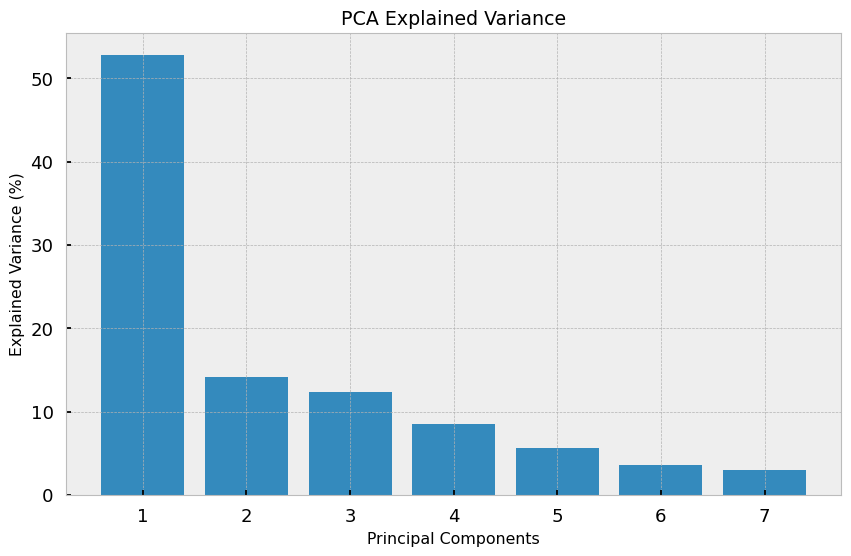

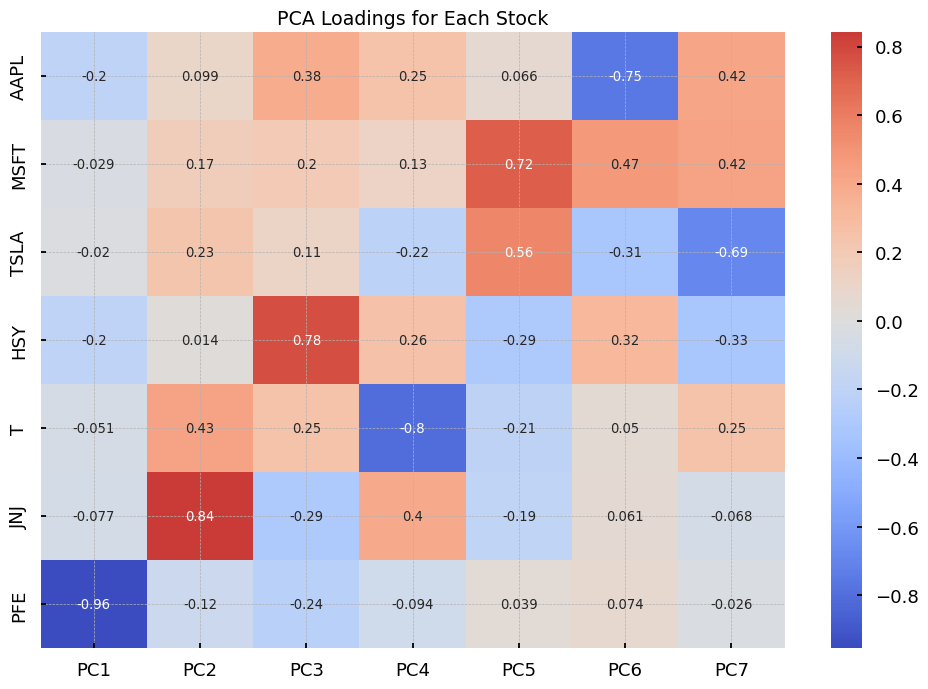

In [25]:

# Step 6: Plot the explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(tickers) + 1), explained_variance * 100)
plt.ylabel('Explained Variance (%)')
plt.xlabel('Principal Components')
plt.title('PCA Explained Variance')
plt.show()

# Visualizing PCA loadings
plt.figure(figsize=(12, 8))
sns.heatmap(pca_loadings, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Loadings for Each Stock')
plt.show()
